# Setup

In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
import joblib

# Load Dataset

In [23]:
url_dataset = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vR1hUlRhTJQgNzSbTyRtDNh1mCrbfy0iUm6oiHK7oHb_iQQ5t7XCB_xyUCwoZ2fdg/pub?output=xlsx'
sheet_name = 'Binary Classification'

In [24]:
queries = pd.read_excel(url_dataset, sheet_name=sheet_name)
queries

,query,label
0,How much is the fee for a multiple-entry visa ...,1
1,Random question number 88,0
2,"Hello, good morning",0
3,Random question number 94,0
4,Best time to see cherry blossoms in Japan?,0
...,...,...
595,Paano po mag apply? pls,1
596,"Hi, Is travel insurance required?",1
597,Help me debug my Java code pls pls,0
598,"Hey, What is the time in New York?",0


In [25]:
queries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   query   600 non-null    object
 1   label   600 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 9.5+ KB


In [26]:
queries['label'].value_counts(normalize=True)

label
1    0.5
0    0.5
Name: proportion, dtype: float64

# Data Preprocessing

In [27]:
X, y = queries['query'], queries['label']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [29]:
len(X_train), len(X_test), len(y_train), len(y_test)

(480, 120, 480, 120)

# Training

In [30]:
class MyTextCleaner(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = pd.Series(X)
        return X.apply(lambda x: x.lower())

In [31]:
class MyEmbeddingTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, model_name: str):
        self.model_name = model_name
        self.model = SentenceTransformer(model_name_or_path=model_name)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = pd.Series(X)
        texts = [f"query: {x}" for x in X.tolist()]
        return np.array(
            self.model.encode(texts, convert_to_numpy=True, normalize_embeddings=True)
        )

In [32]:
pipeline = Pipeline([
    ('text_cleaner', MyTextCleaner()),
    ('embedder', MyEmbeddingTransformer(model_name='intfloat/multilingual-e5-base')),
    ('classifier', LogisticRegression())
])
pipeline.fit(X_train, y_train)

/Users/krimssmirk/Desktop/rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1520: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


,steps,"[('text_cleaner', ...), ('embedder', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,model_name,'intfloat/multilingual-e5-base'
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1


# Train Results

In [33]:
y_pred = pipeline.predict(X_train)

/Users/krimssmirk/Desktop/rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1520: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [34]:
precision = precision_score(y_true=y_train, y_pred=y_pred)
recall = recall_score(y_true=y_train, y_pred=y_pred)

print("Precision:", precision)
print("Recall:", recall)

Precision: 0.9448818897637795
Recall: 1.0


/Users/krimssmirk/Desktop/rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1520: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


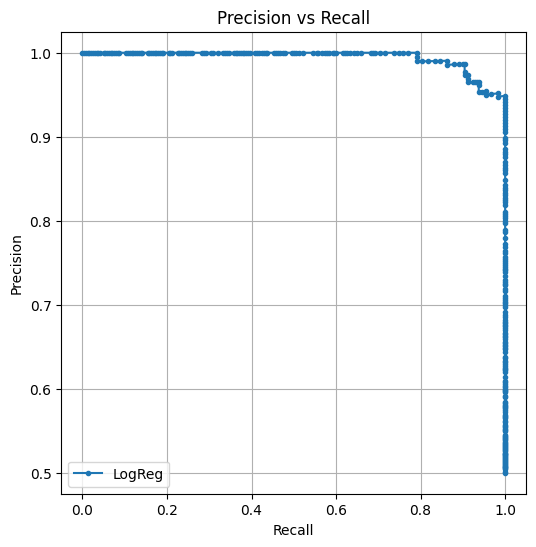

In [35]:
y_scores = pipeline.predict_proba(X_train)[:, 1]

# Compute precision, recall
precision, recall, thresholds = precision_recall_curve(y_train, y_scores)

# Plot
plt.figure(figsize=(6, 6))
plt.plot(recall, precision, marker=".", label="LogReg")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision vs Recall")
plt.legend()
plt.grid(True)
plt.show()

# Evaluations

In [36]:
y_pred = pipeline.predict(X_test)

/Users/krimssmirk/Desktop/rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1520: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [37]:
precision = precision_score(y_true=y_test, y_pred=y_pred)
recall = recall_score(y_true=y_test, y_pred=y_pred)

print("Precision:", precision)
print("Recall:", recall)

Precision: 0.8823529411764706
Recall: 1.0


/Users/krimssmirk/Desktop/rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1520: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


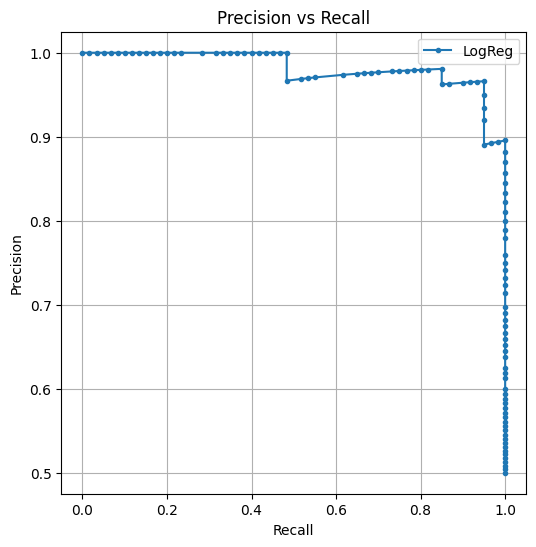

In [38]:
y_scores = pipeline.predict_proba(X_test)[:, 1]

# Compute precision, recall
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Plot
plt.figure(figsize=(6, 6))
plt.plot(recall, precision, marker=".", label="LogReg")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision vs Recall")
plt.legend()
plt.grid(True)
plt.show()

# Real World Test

In [39]:
from typing import Literal

def is_japan_visa_related(query: str, classifier: Pipeline) -> Literal['related', 'not related']:
    result = classifier.predict([query])
    return 'related' if result[0] == 1 else 'not related'

In [40]:
query = 'good morning po'
is_japan_visa_related(query=query, classifier=pipeline)

/Users/krimssmirk/Desktop/rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1520: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


'not related'

# Save the model

In [41]:
pipeline.named_steps['classifier']

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [42]:
joblib.dump(pipeline.named_steps['classifier'], 'japan_visa_related_classifier.pkl')

['japan_visa_related_classifier.pkl']